In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install libraries
!pip install opencv-python
!pip install deepface
!pip install retina-face

!pip install spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=15f152e534c3f376856e0a7c51630732a685270dd669f0d3ad72da50b42cb758
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-pytho

In [ ]:
# Import libraries and modules
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from numpy import argmax
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from nltk.translate.bleu_score import corpus_bleu

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Set folder/file path
ROOT_PATH = "drive/MyDrive/flickr5k"
EVALUATION_IMAGES_PATH = 'drive/MyDrive/evaluation_images/images'
EVALUATION_CAPTIONS_FILE = 'drive/MyDrive/evaluation_images/captions.txt'

In [ ]:
# Import model
model = tf.keras.models.load_model(ROOT_PATH+'/flickr5k_model.h5')
tokenizer = Tokenizer()
with open(ROOT_PATH+'/flickr5k_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Generate Caption

In [ ]:
def get_feature(img_name):
    # Load and restructure vgg16 model
    temp_model = VGG16()
    temp_model = Model(inputs=temp_model.inputs, outputs=temp_model.layers[-2].output)

    image = load_img(os.path.join(EVALUATION_IMAGES_PATH, img_name),target_size=(224, 224))

    # Change to array, expand a new dim, preprocess_input and extract feature 
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = temp_model.predict(image, verbose=0)

    return feature

In [ ]:
def generate_caption(img_name):
    K.clear_session()
    feature = get_feature(img_name)
    caption = "captionbegin"
    
    # iterate over the max words length of sentence (35)
    for i in range(35):
        # encode and pad the sentence
        seq = pad_sequences([tokenizer.texts_to_sequences([caption])[0]],35)
        # predict next word and select the highest probability next word 
        next_word_prob = model.predict([feature, seq], verbose=0)
        word = tokenizer.index_word[argmax(next_word_prob)]
        # remove captionbegin and captionend
        if word != "captionend" and word is not None:
            caption += " " + word
        else:
            caption = " ".join(caption.split(" ")[1:])
            break
    return caption

# BLEU Score

In [ ]:
evaluation_captions_dic = dict()
evaluation_images_set = set()

f = open(EVALUATION_CAPTIONS_FILE, 'r')

# Import evaluation captions
for line in f:
    # split the line by comma(,)
    img_name = line.split(',')[0]
    evaluation_caption = line.split(',')[1].rstrip('\n')
    evaluation_caption = evaluation_caption.replace(' .','').lower()

    # create list if needed
    if img_name not in evaluation_captions_dic:
        evaluation_captions_dic[img_name] = []
        evaluation_images_set.add(img_name)
    # store the caption
    evaluation_captions_dic[img_name].append(evaluation_caption)

In [ ]:
# Calculate BLEU score
BLEU1, BLEU2, BLEU3, BLEU4, count = 0, 0, 0, 0, 0
bleu1_list = list()
bleu2_list = list()

# For each evaluation image, predict the caption and get BLEU1 and BLEU2 score
for img_name in evaluation_images_set:
    count += 1
    evaluation_captions = evaluation_captions_dic[img_name]
    actual = [[evaluation_caption.split() for evaluation_caption in evaluation_captions]]
    predict = [generate_caption(img_name).split()]

    thisBLEU1 = corpus_bleu(actual, predict, weights=(1, 0, 0, 0))
    thisBLEU2 = corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0))
    print(img_name,float("{:.4}".format(thisBLEU1)),float("{:.4}".format(thisBLEU2)))

    bleu1_list.append(float("{:.4}".format(thisBLEU1)))
    bleu2_list.append(float("{:.4}".format(thisBLEU2)))
    BLEU1 += thisBLEU1
    BLEU2 += thisBLEU2
    
print("BLEU-1:",float("{:.4}".format(BLEU1/count)))
print("BLEU-2:",float("{:.4}".format(BLEU2/count)))

553467096/553467096 [==============================] - 20s 0us/step
4970966523.jpg 0.6595 0.4854


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1034276567.jpg 0.7143 0.345
3914088687.jpg 0.5488 0.4753


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


3927610545.jpg 0.2195 5.178e-155
18835207.jpg 0.7273 0.4671
13651137.jpg 0.5455 0.4045
17516940.jpg 0.5 0.2774
4967841904.jpg 0.4286 9.765e-155
18924662.jpg 0.25 7.458e-155
10010052.jpg 0.4545 0.2132
15859665.jpg 0.5966 0.2583
12904242.jpg 0.696 0.558
3899256790.jpg 0.5 0.2132
8243477528.jpg 0.3333 0.1543
3952790386.jpg 0.7143 0.5742
10815824.jpg 0.5 0.2673
16933558.jpg 0.3529 0.1485
19541210.jpg 0.75 0.5222
11391827.jpg 0.5 0.3693
18965154.jpg 0.3571 8.914e-155
1007320043.jpg 1.0 0.8452
8140263558.jpg 0.4545 0.2132
18865365.jpg 0.5338 0.2312
18638572.jpg 0.6875 0.4282
1150429218.jpg 0.5 0.1826
10956999.jpg 0.3 8.17e-155
16793868.jpg 0.4232 0.2677
14264287.jpg 0.4444 0.2357
17314123.jpg 0.5333 0.276
3902127239.jpg 0.3977 8.899e-155
11808546.jpg 0.6364 0.4369
4036817468.jpg 0.5134 0.4592
19245206.jpg 0.5 0.1961
12243003.jpg 0.241 0.1347
14799369.jpg 0.5 0.2673
8189395281.jpg 0.5 0.2132
12526324.jpg 0.5 0.1961
16396205.jpg 0.25 7.458e-155
16495609.jpg 0.25 0.189
10404007.jpg 0.625 0.2988

In [ ]:
print(bleu1_list)
print(bleu2_list)

[0.6595, 0.7143, 0.5488, 0.2195, 0.7273, 0.5455, 0.5, 0.4286, 0.25, 0.4545, 0.5966, 0.696, 0.5, 0.3333, 0.7143, 0.5, 0.3529, 0.75, 0.5, 0.3571, 1.0, 0.4545, 0.5338, 0.6875, 0.5, 0.3, 0.4232, 0.4444, 0.5333, 0.3977, 0.6364, 0.5134, 0.5, 0.241, 0.5, 0.5, 0.5, 0.25, 0.25, 0.625]
[0.4854, 0.345, 0.4753, 5.178e-155, 0.4671, 0.4045, 0.2774, 9.765e-155, 7.458e-155, 0.2132, 0.2583, 0.558, 0.2132, 0.1543, 0.5742, 0.2673, 0.1485, 0.5222, 0.3693, 8.914e-155, 0.8452, 0.2132, 0.2312, 0.4282, 0.1826, 8.17e-155, 0.2677, 0.2357, 0.276, 8.899e-155, 0.4369, 0.4592, 0.1961, 0.1347, 0.2673, 0.2132, 0.1961, 7.458e-155, 0.189, 0.2988]


In [ ]:
# Analyse BLEU1
a = np.array(bleu1_list)
print(float("{:.4}".format(np.percentile(a, 100))))
print(float("{:.4}".format(np.percentile(a, 75))))
print(float("{:.4}".format(np.percentile(a, 50))))
print(float("{:.4}".format(np.percentile(a, 25))))
print(float("{:.4}".format(np.percentile(a, 0))))

1.0
0.6037
0.5
0.4168
0.2195


In [ ]:
# Analyse BLEU2
a = np.array(bleu2_list)
print(float("{:.4}".format(np.percentile(a, 100))))
print(float("{:.4}".format(np.percentile(a, 75))))
print(float("{:.4}".format(np.percentile(a, 50))))
print(float("{:.4}".format(np.percentile(a, 25))))
print(float("{:.4}".format(np.percentile(a, 0))))

0.8452
0.4104
0.247
0.1755
5.178e-155


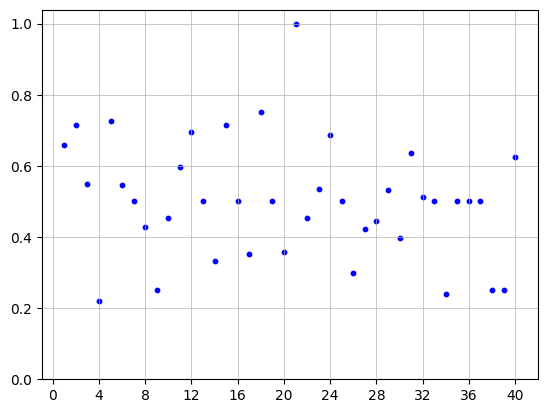

In [ ]:
# Plot BLEU-1 scores
for count in range(len(bleu1_list)):
    plt.scatter(count+1, bleu1_list[count], s = 10, color = 'blue')

plt.xticks(np.arange(0, 41, 4.0))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid(linewidth = 0.5, which = "both")
plt.show()

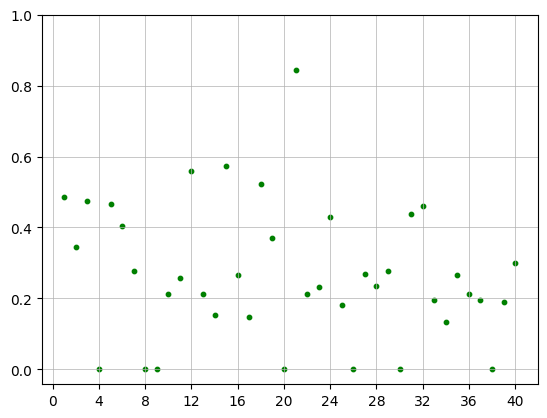

In [ ]:
# Plot BLEU-2 scores
for count in range(len(bleu1_list)):
    plt.scatter(count+1, bleu2_list[count], s = 10, color = 'green')

plt.xticks(np.arange(0, 41, 4.0))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid(linewidth = 0.5, which = "both")
plt.show()

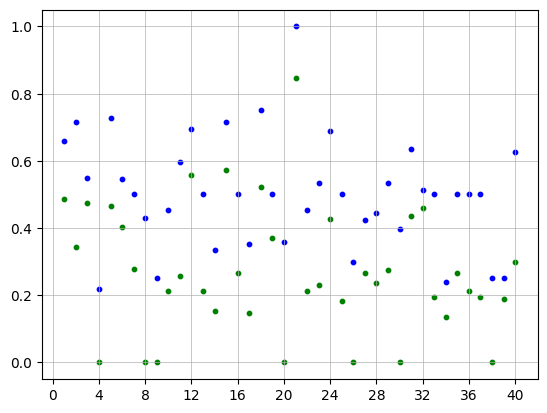

In [ ]:
# Plot BLEU-1 and BLEU-2
for count in range(len(bleu1_list)):
    plt.scatter(count+1, bleu1_list[count], s = 10, color = 'blue')
    plt.scatter(count+1, bleu2_list[count], s = 10, color = 'green')

plt.xticks(np.arange(0, 41, 4.0))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid(linewidth = 0.5, which = "both")
plt.show()

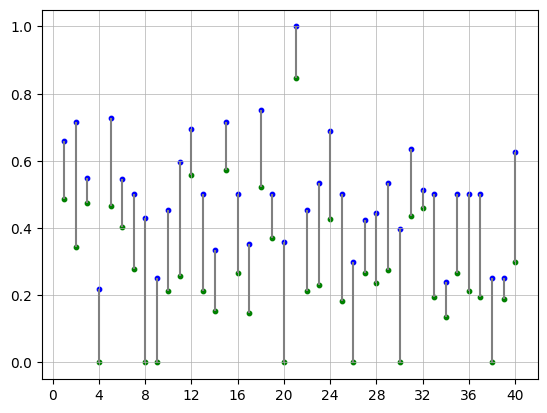

In [ ]:
# Plot BLEU-1 and BLEU-2, connected by lines
for count in range(len(bleu1_list)):
    plt.vlines(x = count+1, ymin = bleu2_list[count], ymax = bleu1_list[count],
            linestyles='solid', color="grey")
    plt.scatter(count+1, bleu1_list[count], s = 10, color = 'blue')
    plt.scatter(count+1, bleu2_list[count], s = 10, color = 'green')

plt.xticks(np.arange(0, 41, 4.0))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.grid(linewidth = 0.5, which = "both")
plt.show()

In [ ]:
# Calculate the average difference between BLEU-1 and BLEU-2
diff_list = list()
for n in range(40):
    diff_list.append(bleu1_list[n] - bleu2_list[n])
print(sum(diff_list) / 40)

0.23335249999999993


# Emotion

In [ ]:
import cv2
import matplotlib.pyplot as plt
from retinaface import RetinaFace
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
def extract_emotion(img):
    faces = RetinaFace.extract_faces(img)
    dominant_region = 0
    dominant_emotion = ''
    # Find the emotion of the most dominant face, i.e. face with the largest region
    for face in faces:
        prediction = DeepFace.analyze(face, detector_backend = 'skip')
        region = prediction[0]["region"]['w'] * prediction[0]["region"]['h']
        if region > dominant_region:
            dominant_emotion = prediction[0]["dominant_emotion"]
            dominant_region = region
    emotion = dominant_emotion
    return emotion

# Combine Caption and Emotion

In [ ]:
import spacy

In [ ]:
def combine(old_caption, emotion):
    print("emotion:",emotion)
    # If emotion is neutral, change to calm, peaceful or nothing randomly
    if emotion == "neutral":
        randon_num = random.randint(0, 2)
        if randon_num == 0:
            emotion = "calm"
        elif randon_num == 1:
            emotion = "peaceful"
        else:
            emotion = ""

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(old_caption)
    new_list=[]
    # Iterate over the tokens in the sentence
    for token in doc:
        # If the token is an nsubj, add the emotion as an adjective before it
        if token.dep_ == "nsubj":
            new_list.append(emotion)
        token_idx = token.i
        new_list.append(doc[token_idx].text)

    new_caption = ' '.join([item for item in new_list])
    print("caption without emotion:",old_caption)
    print("caption with emotion:",new_caption)

# Final

In [ ]:
def generate_caption_with_emotion(img_name):
    # Read the image, show the image, get its caption, emotion and improved caption with emotion.
    img = cv2.imread(os.path.join(EVALUATION_IMAGES_PATH, img_name))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
    caption = generate_caption(img_name)
    emotion = extract_emotion(img)
    final_caption = combine(caption, emotion)

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 70.7MB/s]
Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 11.5MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:07<00:00, 68.4MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:08<00:00, 61.7MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:07<00:00, 67.3MB/s]
Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


emotion: neutral
caption without emotion: a little girl in red climbs a rope
caption with emotion: a little girl in red climbs a rope


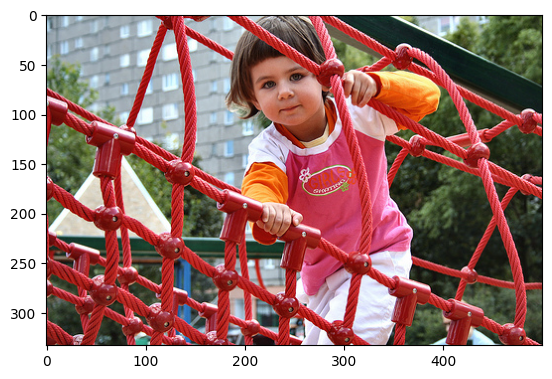

In [ ]:
generate_caption_with_emotion("1007320043.jpg")

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


emotion: surprise
caption without emotion: a little boy in a blue shirt is playing in the water
caption with emotion: a little surprise boy in a blue shirt is playing in the water


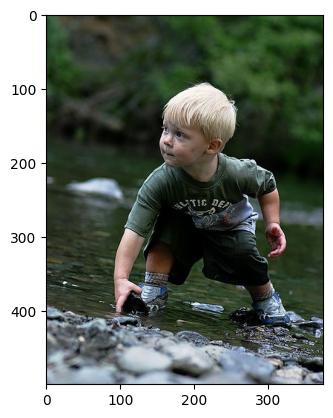

In [ ]:
generate_caption_with_emotion("19541210.jpg")

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


emotion: neutral
caption without emotion: a girl in a wetsuit jumps into a pool
caption with emotion: a peaceful girl in a wetsuit jumps into a pool


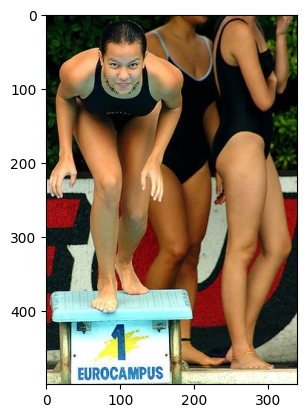

In [ ]:
generate_caption_with_emotion("12904242.jpg")

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


emotion: neutral
caption without emotion: a little boy is playing with a red toy
caption with emotion: a little calm boy is playing with a red toy


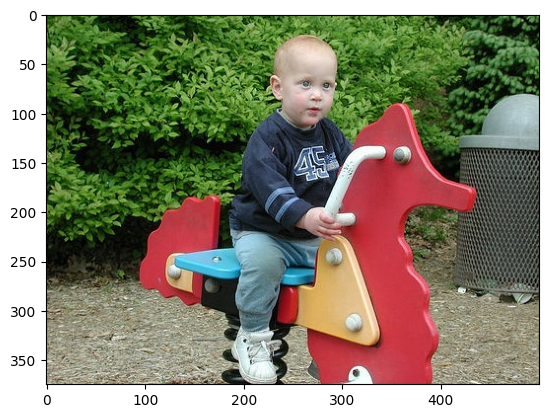

In [ ]:
generate_caption_with_emotion("15859665.jpg")

Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


emotion: angry
caption without emotion: a man riding a horse
caption with emotion: a man riding a horse


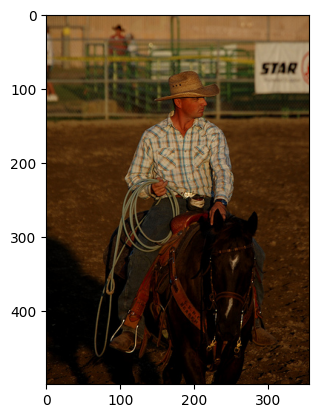

In [ ]:
generate_caption_with_emotion("3914088687.jpg")